# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model
from fastscape.processes import MultipleFlowRouter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import paraspec.taxon_lineage as txl

from paraspec.fastscape_ext import IR12Speciation, DD03Speciation, CompoundEnvironment, ElevationEnvField1, ElevationEnvField2 

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'elevation2':ElevationEnvField2,
    'life': IR12Speciation,
    'flow': MultipleFlowRouter
})

model

<xsimlab.Model (20 processes, 24 inputs)>
grid
    shape               [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length              [in] ('shape_yx',) total grid length in (y, x)
boundary
    status              [in] () or ('border',) node status at borders
fs_context
uplift
    rate                [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                [in] random seed
surf2erode
flow
    slope_exp           [in] () or ('y', 'x') MFD partioner slope e...
drainage
spl
    k_coef              [in] () or ('y', 'x') bedrock channel incis...
    area_exp            [in] drainage area exponent
    slope_exp           [in] slope exponent
init_erosion
diffusion
    diffusivity         [in] () or ('y', 'x') diffusivity (transpor...
erosion
vmotion
topography
terrain
elevation2
elevation1
life_env
life
    init_abundance      [in] initial number of individuals
    init_min_trait      [in] ('trait',) initial min trait value
    init_max_trait      [in] ('tra

In [3]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201], #[201, 201],
        'grid__length': [1e5, 2e5], #[2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_abundance': 100,
            'init_max_trait': [0.5, 0.5],#[0.5],#
            'init_min_trait': [0.5, 0.5],#[0.5],#
            'slope_trait_env': [0.95, -0.95],#[0.95],#
            'min_env': [0, 0],#[0],#
            'max_env': [400, 400],#[400],#
            'nb_radius': 2e4,#2e3
            'car_cap': 30, #25
            'sigma_mov': 1000.,
            'mut_prob': 0.05,
            'sigma_mut': 0.05, 
            'sigma_env_trait': 0.3, 
            'random_seed': 1234,
            'rescale_rates':False,
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out',
        'life__n_offspring': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [4]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

In [5]:
out_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 101, y: 101, x: 201, shape_yx: 2, ind: 470, trait: 2, field: 2, time: 101)
Coordinates:
  * border                  (border) object 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * x                       (x) float64 0.0 1e+03 2e+03 ... 1.99e+05 2e+05
  * y                       (y) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx, ind, trait, field
Data variables: (12/34)
    boundary__status        (border) <U11 'looped' 'looped' ... 'fixed_value'
    diffusion__diffusivity  float64 0.001
    drainage__area          (out, y, x) float64 1.946e+06 ... 3.911e+06
    flow__slope_exp         float64 1.0
    grid__length            (shape_yx) float64 1e+05 2e+05
    grid__shape             (shape_yx) int64 101 201
    ...                      ...
    life__y                 (out, ind) float64 5.724e+04 4.91e+04 ... nan nan
    spl__area_exp           float64 0.4
    spl__k_coef             float64 0.0001
    spl__slope_exp          int64 1
    topography__elevation   (out, y, x) float64 0.9826 0.3464 ... 0.674 0.6582
    uplift__rate            float64 0.001

In [6]:
individuals_data = {}
for i in range(out_ds.life__trait.shape[2]):
    individuals_data['life__trait_'+str(i)] = out_ds.life__trait[:,:,i]
out_ds=out_ds.assign(individuals_data)

In [7]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
)

df

,out,ind,ancestor_id,id,n_offspring,parent,taxon_id,x,y,trait_0,trait_1
id,,,,,,,,,,,
1.0,0.0,1,0.0,1.0,1.0,1.0,1.0,414.215347,49101.865736,0.500000,0.500000
3.0,0.0,3,0.0,3.0,1.0,3.0,1.0,161361.778440,46378.641078,0.500000,0.500000
8.0,0.0,8,0.0,8.0,1.0,8.0,1.0,146186.247303,64638.600514,0.500000,0.500000
9.0,0.0,9,0.0,9.0,1.0,9.0,1.0,136494.208833,42140.410817,0.500000,0.500000
10.0,0.0,10,0.0,10.0,1.0,10.0,1.0,152518.261768,22633.227006,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
34942.0,990000.0,462,1190.0,34942.0,1.0,34475.0,1201.0,169458.873773,63365.292011,0.412335,0.495812
34943.0,990000.0,463,1176.0,34943.0,1.0,34476.0,1217.0,188889.412267,66534.462453,0.456798,0.522691
34944.0,990000.0,464,1176.0,34944.0,1.0,34477.0,1217.0,172413.534189,63426.786247,0.451802,0.524531


In [8]:
df.loc[df.out==10000]

,out,ind,ancestor_id,id,n_offspring,parent,taxon_id,x,y,trait_0,trait_1
id,,,,,,,,,,,
100.0,10000.0,0,1.0,100.0,2.0,1.0,2.0,229.500646,49364.227328,0.500000,0.500000
101.0,10000.0,1,1.0,101.0,3.0,3.0,2.0,159459.264449,45765.788773,0.500000,0.500000
102.0,10000.0,2,1.0,102.0,2.0,8.0,2.0,146487.351450,64753.611104,0.500000,0.500000
103.0,10000.0,3,1.0,103.0,2.0,9.0,2.0,136733.520242,43655.484753,0.500000,0.500000
104.0,10000.0,4,1.0,104.0,3.0,10.0,2.0,153119.370797,21857.493294,0.500000,0.500000
105.0,10000.0,5,1.0,105.0,3.0,16.0,2.0,144939.094398,2227.918587,0.500000,0.500000
106.0,10000.0,6,1.0,106.0,2.0,18.0,2.0,196188.668261,17015.255262,0.500000,0.500000
107.0,10000.0,7,1.0,107.0,3.0,20.0,2.0,9576.685931,1659.444113,0.500000,0.500000
108.0,10000.0,8,1.0,108.0,3.0,24.0,2.0,564.983762,91983.375145,0.500000,0.500000


## Plot population

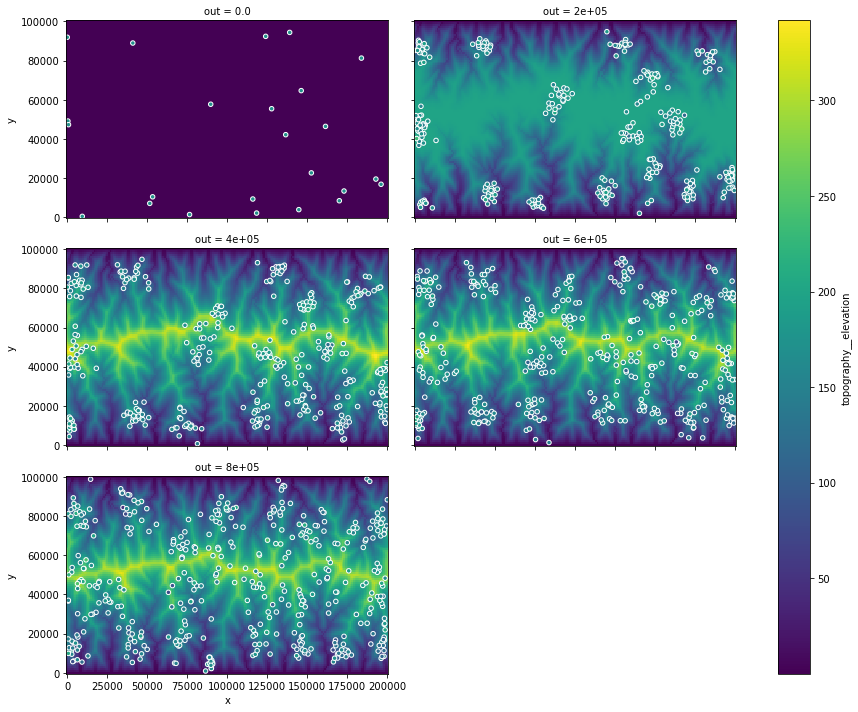

In [9]:
times = np.arange(0, 1e6, 2e5)
elev_max = out_ds.topography__elevation.max()


fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_0, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

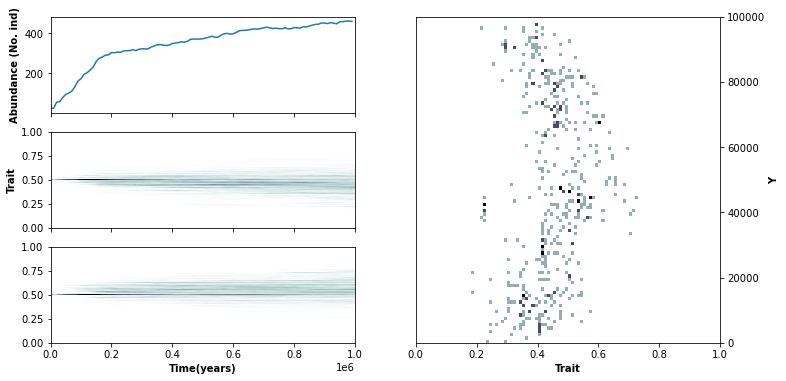

In [10]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, -1]:
    ax.remove()
axbig = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait_0'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df['out'], y=df['trait_1'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df['trait_0'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')

axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs2[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1,0].set_ylabel('Trait', weight='bold')
axs2[2,0].set_xlabel('Time(years)', weight='bold')

In [11]:
taxon_lineage1 = txl.dtf_taxon(df.rename(columns={'out':'time'}))
taxon_lineage1

,time,id,parent,trait_0,trait_1,abundance,node_type,branch_length
0,0.0,1.0,0.0,0.500000,0.500000,24,root,0.001
1,10000.0,2.0,1.0,0.500997,0.500808,24,node,10000.001
2,20000.0,3.0,2.0,0.501130,0.502916,54,node,10000.001
3,30000.0,4.0,3.0,0.500747,0.504511,57,node,10000.001
4,40000.0,5.0,4.0,0.502206,0.506903,78,node,10000.001
...,...,...,...,...,...,...,...,...
1220,990000.0,1221.0,1184.0,0.380646,0.572056,24,leaf,0.001
1221,990000.0,1222.0,1181.0,0.497904,0.592632,10,leaf,0.001
1222,990000.0,1223.0,1182.0,0.408454,0.382220,7,leaf,0.001
1223,990000.0,1224.0,1179.0,0.532443,0.518577,13,leaf,0.001


In [12]:
tree1 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage1)

In [13]:
tree1.print_plot()

                                         /++++++++++++++++++++++++++++++ 1206.0
             +++++++++++++++++++++++++++++                                     
             |                           |                      ++++++++ 1222.0
             |                           \+++++++++++++++++++++++              
             |                                                  ++++++++ 1221.0
             |                                                                 
     /++++++++                                /+++++++++++++++++++++++++ 1201.0
     |       |         /+++++++++++++++++++++++                                
     |       |         |                      |             /+++++++++++ 1220.0
     |       |         |                      \++++++++++++++                  
     |       |         |                                    \+++++++++++ 1215.0
     |       +++++++++++                                                       
     |                 |                

## Speciation with competition in an evolving landscape

In [14]:
model2 = basic_model.update_processes({
    'life_env': CompoundEnvironment,
    'elevation1':ElevationEnvField1,
    'elevation2':ElevationEnvField2,
    'life': DD03Speciation,
    'flow': MultipleFlowRouter
})
model2

<xsimlab.Model (20 processes, 27 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                 [in] random seed
surf2erode
flow
    slope_exp            [in] () or ('y', 'x') MFD partioner slope ...
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
init_erosion
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
erosion
vmotion
topography
terrain
elevation2
elevation1
life_env
life
    init_abundance       [in] initial number of individuals
    init_min_trait       [in] ('trait',) initial min trait value
    init_max_trait       [i

In [15]:
in_ds2 = xs.create_setup(
    model=model2,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201],
        'grid__length': [1e5, 2e5],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_abundance': 100,
            'init_min_trait': [0.5, 0.5],
            'init_max_trait': [0.5, 0.5],
            'slope_trait_env': [0.95, -0.95],
            'min_env': [0, 0],
            'max_env': [400, 400],
            'birth_rate': 1.,
            'movement_rate': 5.,
            'car_cap_max': 500.,
            'sigma_env_trait': 0.3,
            'mut_prob': 0.05,
            'sigma_mut': 0.05,
            'sigma_mov': 1000.,
            'sigma_comp_trait': 0.9,
            'sigma_comp_dist': 0.1,
            'random_seed': 1234,
            'rescale_rates': False
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out',
        'life__n_offspring': 'out',
        'life__taxon_id': 'out',
        'life__ancestor_id': 'out'
    }
)

In [16]:
with xs.monitoring.ProgressBar():
    out_ds2 = in_ds2.xsimlab.run(model=model2)

             0% | initialize 

In [17]:
individuals_data2 = {}
for i in range(out_ds2.life__trait.shape[2]):
    individuals_data2['life__trait_'+str(i)] = out_ds2.life__trait[:,:,i]
out_ds2=out_ds2.assign(individuals_data2)

In [18]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds2.dims if d not in ('out', 'ind')])
    .drop_vars(in_ds2, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'ind'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
)


df2

,out,ind,ancestor_id,id,n_offspring,parent,taxon_id,x,y,trait_0,trait_1
id,,,,,,,,,,,
1.0,0.0,1,0.0,1.0,1.0,1.0,1.0,414.215347,49101.865736,0.500000,0.500000
2.0,0.0,2,0.0,2.0,1.0,2.0,1.0,161871.264117,71968.886030,0.500000,0.500000
3.0,0.0,3,0.0,3.0,1.0,3.0,1.0,161361.778440,46378.641078,0.500000,0.500000
4.0,0.0,4,0.0,4.0,2.0,4.0,1.0,10906.533328,85111.346187,0.500000,0.500000
5.0,0.0,5,0.0,5.0,1.0,5.0,1.0,19787.256556,78833.267136,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
6035.0,990000.0,570,1477.0,6035.0,1.0,5924.0,1530.0,52576.103116,44789.263269,0.500000,0.500000
6036.0,990000.0,571,1477.0,6036.0,2.0,5928.0,1530.0,50992.810452,72994.168600,0.482617,0.507816
6037.0,990000.0,572,1477.0,6037.0,2.0,5930.0,1530.0,164886.446809,71018.565839,0.406951,0.573901


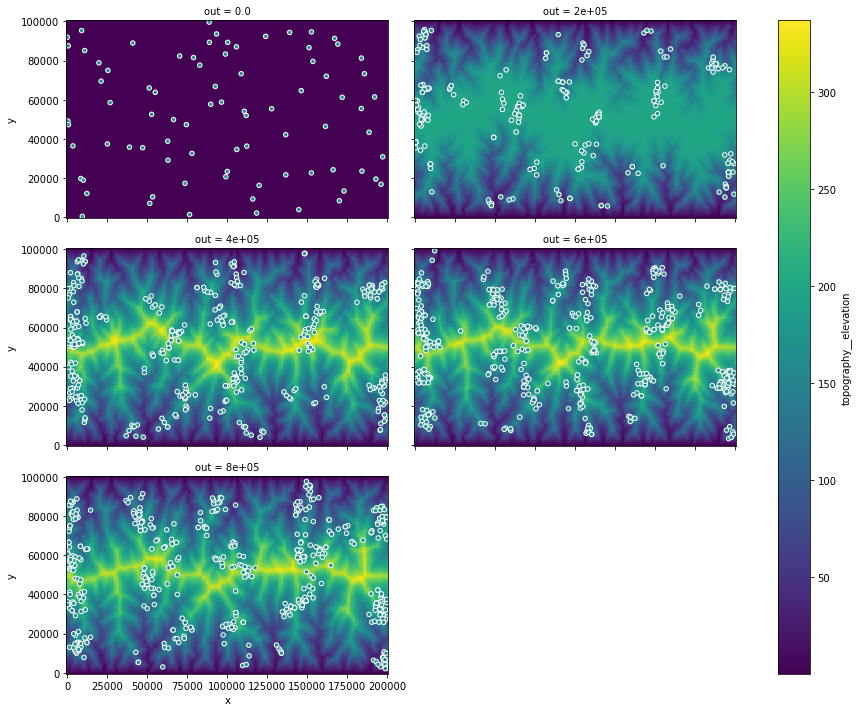

In [19]:
times = np.arange(0, 1e6, 2e5)
elev_max = out_ds2.topography__elevation.max()


fg = (out_ds2
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait_0, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

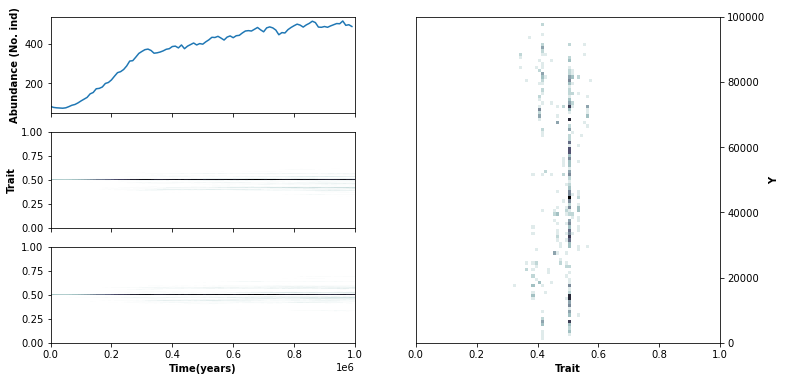

In [20]:
fig5, axs5 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, -1]:
    ax.remove()
axbig = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait_0'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df2['trait_0'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axs5[2,0].hist2d(x=df2['out'], y=df2['trait_1'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs5[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs5[1,0].set_ylabel('Trait', weight='bold')
axs5[2,0].set_xlabel('Time(years)', weight='bold')

In [21]:
taxon_lineage2 = txl.dtf_taxon(df2.rename(columns={'out':'time'}))
taxon_lineage2

,time,id,parent,trait_0,trait_1,abundance,node_type,branch_length
0,0.0,1.0,0.0,0.500000,0.500000,81,root,0.001
1,10000.0,2.0,1.0,0.500000,0.500000,76,node,10000.001
2,20000.0,3.0,2.0,0.500000,0.500000,74,node,10000.001
3,30000.0,4.0,3.0,0.500000,0.500000,73,node,10000.001
4,40000.0,5.0,4.0,0.500220,0.499712,72,node,10000.001
...,...,...,...,...,...,...,...,...
1524,990000.0,1528.0,1475.0,0.477682,0.490915,34,leaf,0.001
1525,990000.0,1529.0,1476.0,0.481752,0.491852,2,leaf,0.001
1526,990000.0,1530.0,1477.0,0.490529,0.521942,16,leaf,0.001
1527,990000.0,1531.0,1479.0,0.479674,0.504936,4,leaf,0.001


In [22]:
tree2 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage2)

In [23]:
tree2.print_plot()

                 /++++++++++++++++++++++++++++++++++++++++++++++++++++++ 1523.0
                 |                                                             
                 |++++++++++++++++++++++++++++++++++++++++++++++++++++++ 1531.0
                 ||                                                            
                 ||                                               /+++++ 1514.0
                 ||                                         /++++++            
                 ||                                         |     |   /+ 1526.0
                 ||/+++++++++++++++++++++++++++++++++++++++++     \++++        
                 |||                                        |         \+ 1528.0
                 |||                                        |                  
                /+||                                        \+++++++++++ 1529.0
                ||||                                                           
                |||| +++++++++++++++++++